In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from casadi import *
import time 
from statistics import mean
import scipy.linalg as lin
from scipy import signal

In [2]:
def plot_trajectories(x, u, dt, title=""):
    time = np.arange(0, x.shape[1]) * dt
    plt.figure()
    plt.plot(time, x[0,:],label='$\Theta$')
    plt.plot(time, x[1,:],label='$\dot{\Theta}$')
    plt.plot(time, x[2,:],label='$x$')
    plt.plot(time, x[3,:],label='$\dot{x}$')
    plt.plot(time[:-1],u,'--',label='$u$') #
    plt.grid()
    plt.legend()
    plt.title(title)
    plt.xlabel("$t$ [s]")
    
    print(f"theta at end {x[0,-1]} {title}")

In [3]:
def rk4(system,dt):
    """
    Discretisation of the continuous system using Runge-Kutta 4 discretisation scheme
    
    Inputs:    
    i.system :The Casadi function describing the system
    ii. dt: step size/sampling time
    
    Outputs:
    i. rksys : Discretised system (as a Casadi function)
    """    
    k1 = system(x,u)
    k2 = system(x+dt/2*k1,u)
    k3 = system(x+dt/2*k2,u)
    k4 = system(x+dt*k3,  u)
    xf = x + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    rksys = Function("Discrete_System",[x,u],[xf])
    return rksys

In [9]:
def lqr(system,Q,R,x,u,dt):
    xdot = system(x,u)
    nx = x.shape[0]
    nu = u.shape[0]

    A_fun = Function('Linearized_A',[x,u],[jacobian(xdot,x)])
    B_fun = Function('Linearized_B',[x,u],[jacobian(xdot,u)])

    xs = np.zeros([nx,1])
    us = np.zeros([nu,1])

    A = A_fun(xs,us)
    B = B_fun(xs,us)
    C = np.eye(nx)
    D = np.zeros([nx,nu])

    sys = signal.StateSpace(A,B,C,D)
    sys_d = sys.to_discrete(dt=dt)
    A_d = sys_d.A
    B_d = sys_d.B

    P = lin.solve_discrete_are(A_d,B_d,Q,R)

    return P

In [119]:
def Optimize_fcn(x_0,T,nx,nu,system,u,x,h,init_guess=None, solver="ipopt",verbose=False,state_constraint=True, input_constraint=True):
    """
    A function that creates an optimization solver and returns optimal state and input trajectories.
    The optimization problem is defined as:
    
    minimize     sum_{k=0}^{N-1} x(k).T*Q*x(k) + u(k).T*R*u(k) + x.T*Qt*x
     x,u
    
    Input arguments: 
    i. x_0 : Initial state of the system which acts as the parameter for the optimization solver (Default value = [pi,0,0,0])
    ii. N : Prediction horizon (Default value = 50)
    iii. nx : Number of states 
    iv. nu : Number of inputs
    v. dsys : Discretized system 
    
    Output:
    i. Xtraj : The optimal state trajectory with minimum cost 
    ii. Utraj: The optimal input trajectory with minimum cost
    iii. solver : The optimal control problem solver object  
    """

    N = int(T/h)

    #Weighting parameters Q, R and Qt
    Q = np.diag([1e2, 1, 100, 1]) # theta [-3,3], thetadot , x [-0.4, 0.4], xdot []
    r = 1
    R = r*np.eye(nu)

    dsys = rk4(system, h)

    Qt = lqr(system,Q,R,x,u,h)

    X = SX.sym('X',(N+1)*nx,1) #Vector to store all states for N time steps
    U = SX.sym('U',N*nu) #Vector to store inputs for N time steps
    
    #Stage cost as a function of current state and input
    stage_cost = x.T@ Q @ x+ u.T @R @ u
    stage_cost_fcn = Function('stage_cost',[x,u],[stage_cost])

    #Terminal cost as a function of final state
    terminal_cost = x.T @ Qt @ x
    terminal_cost_fcn = Function('terminal_cost',[x],[terminal_cost])

    # state constraints
    lb_st = []
    ub_st = []
    
    # input constraints"
    lb_u = []
    ub_u = []

    G =[] #Constraint list
    J = 0 #Cost function

    #Adding initial condition to the list of constraints
    X0 = SX.sym('x_init', nx)
    g0 =X[0:nx]-X0
    G.append(g0)
    
    for k in range(N):

        #Extracting current, next states and current input from respective vectors

        x_k = X[k*nx:(k+1)*nx,:]
        x_k_plus = X[(k+1)*nx:(k+2)*nx,:]
        u_k = U[k*nu:(k+1)*nu,:] 
        
        #Stage cost
        J += stage_cost_fcn(x_k,u_k)
        
        #Continuity constraint
        xplus = dsys(x_k,u_k) #Predicting the next state of the system using discretised system
        gk = xplus-x_k_plus 
        G.append(gk) #Difference between predicted state and next state in list added to constraint list
        
        #Updating constraints for states and inputs
        if state_constraint:
            lb_st += [-inf,-inf,-0.3,-inf]
            ub_st += [inf, inf, 0.3, inf]
        else:
            lb_st += [-inf,-inf,-inf,-inf]
            ub_st += [inf, inf, inf, inf]


        if input_constraint:
            lb_u += [-23]
            ub_u += [23]
        else:
            lb_u += [-inf]
            ub_u += [inf]
            
    #Terminal cost
    x_n = X[N*nx:]
    J += terminal_cost_fcn(x_n)
    
    if state_constraint:
        lb_st += [-inf,-inf,-0.3,-inf]
        ub_st += [inf, inf, 0.3, inf]
    else:
        lb_st += [-inf,-inf,-inf,-inf]
        ub_st += [inf, inf, inf, inf]

    #Concatenating the required vectors
    lbw = vertcat(*lb_st, *lb_u)
    ubw = vertcat(*ub_st, *ub_u)
    w = vertcat(X,U)

    prob = {"x":w,"f":J,"g":vertcat(*G),'p':X0}

    if solver == "qpoases":
        opts = {"qpsol": "qrqp"}
        #if not verbose:
           #opts["qpsol_options"] = {"printLevel": "none"}
        opt_solver = nlpsol('solver','sqpmethod',prob, opts)
    else:
        opts = {
        }
        if not verbose:
            opts = {
                **opts,
                'ipopt.print_level': 0,
                'print_time': 0,
                'ipopt.tol':1e-2
            }
        else:
            opts = {
                **opts,
                'ipopt.print_level': 5,
                'print_time': 0,
                'ipopt.tol': 1e-2
            }

        opt_solver = nlpsol('solver','ipopt',prob, opts)


    #init_x, init_u = init_guess
    #x0_init = np.concatenate((init_x.flatten(), init_u[0:N]))
    #x0_init = init_guess

    sol = opt_solver(x0=init_guess, p=x_0,lbx=lbw,ubx=ubw,lbg=0,ubg=0) #Calling solver

    if not opt_solver.stats()["success"]:
        print('OCP not solved') # it doesn't necessarily mean that the OCP is infesible, just that ipopt wasn't capable of finding a solution
    else:
        print("OCP solved")

    opt_X = sol['x'][:(N+1)*nx].full().reshape(N+1, nx)
    opt_U = sol['x'][(N+1)*nx:].full().reshape(N, nu)

    return opt_X,opt_U


In [137]:
def mpc(x_0,x,u,system,T_sim,dt,T,h):
    """
    MPC Algorithm function with inputs:
    i. dsys : Discretized system
    and outputs:
    i. res_x_mpc : Closed loop state trajectory 
    ii. res_u_mpc : Input trajectory
    """
    res_x_mpc =[x_0]
    res_u_mpc = []
    N_sim = int(T_sim/dt)
    N = int(T/h)
    dsys_cl = rk4(system, dt)

    for i in range(N_sim):
              
        if i == 0:           
            init_x, init_u = (np.repeat(x_0,N+1,axis=1).T, [0]*N)
            x0_init = np.concatenate((init_x.flatten(), init_u[0:N]))

            opt_x, opt_u = Optimize_fcn(x=x, u=u, system=system, x_0=x_0, T=T, nx=4, nu=1, h=h,
                                    init_guess=x0_init,
                                    verbose=False, state_constraint=True, input_constraint=True)
            
            
            plot_trajectories(opt_x.T, opt_u, h, title=f"OCP iteration = {i+1}")
    

        if i>0: #Warmstart
            opt_x_next = np.concatenate((np.delete(opt_x,[0,1,2,3]).reshape(N,nx),dsys_cl(opt_x[N,:],opt_u[N-1]).full().reshape(1,nx)),axis=0).reshape(N+1,nx)
            opt_u_next = np.concatenate((np.delete(opt_u,0),opt_u[N-1]),axis=0).reshape(N,1) 
            warm_init = vertcat(*opt_x_next,*opt_u_next)
            
            opt_x,opt_u =  opt_x, opt_u = Optimize_fcn(x=x, u=u, system=system, x_0=x_0, T=T, nx=4, nu=1, h=h,
                                    init_guess=warm_init,
                                    verbose=False, state_constraint=True, input_constraint=True)
            
        #Extract first input from optimal inputs and apply to system
        u_k = opt_u[0]
        xplus = dsys_cl(x_0,u_k).full().reshape(nx,1)

        #Overwrite the current state with the next state
        x_0 = xplus
        
        #Append the relevant values to lists
        res_x_mpc.append(xplus)
        res_u_mpc.append(u_k)  



    #Concatenate the relevant arrays:
    res_x_mpc = np.concatenate(res_x_mpc,axis=1)
    res_u_mpc = np.array(res_u_mpc) #Create a numpy array from list
    
    return res_x_mpc, res_u_mpc


OCP solved
theta at end -0.006121666966780227 OCP iteration = 1
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
OCP solved
O

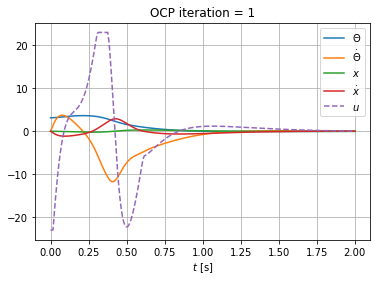

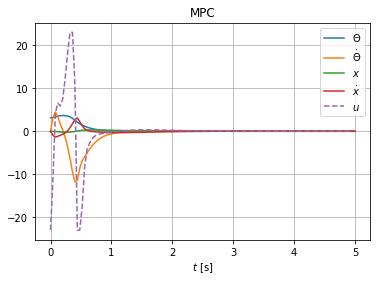

In [138]:

# Timestep
h = 1/125 # OCP integration time
T = 2 # OCP horizon in seconds
dt = 1/25 # Closed loop sampling time
T_sim = 5 # Closed loop simulation time


# Constants in SI units

g = 9.81
l = 0.41
b = 0.016
m = 0.3

# Dimensions of x and u:
nx = 4
nu = 1

# Symbolic variables x and u:
x = SX.sym('x', nx)
u = SX.sym('u', nu)

# right hand side of ODE:
xdot = vertcat(
    x[1],
    (3*g/(2*l))*np.sin(x[0]) - (3*b/(m*l**2))*x[1] + 3/(2*l)*np.cos(x[0])*u,
    x[3],
    u   
)


# Create the CasADi function
system = Function("sys",[x,u],[xdot])
x_0 = np.array([pi,0,0,0]).reshape(nx,1)

x_mpc,u_mpc= mpc(x_0,x,u,system,T_sim,dt,T,h)

plot_trajectories(x_mpc, u_mpc, dt, title="MPC")
plt.show()

In [14]:
N = int(T/h)
opt_x, opt_u = Optimize_fcn(x=x, u=u, system=system, x_0=x_0, T=T, nx=4, nu=1, h=h,
                                    init_guess=(np.repeat(x_0,N+1,axis=1).T, [0]*N),
                                    verbose=False, state_constraint=True, input_constraint=True)

OCP solved


In [88]:
np.delete(opt_x,[0,1,2,3]).reshape(N,nx)

(250, 4)

In [52]:
dsys = rk4(system,dt)

In [78]:
x_next = dsys(opt_x[N,:],opt_u[N-1]).full().reshape(1,nx)

In [87]:
x_next

(1, 4)

In [101]:
opt_x_next = np.concatenate((np.delete(opt_x,[0,1,2,3]).reshape(N,nx),dsys(opt_x[N,:],opt_u[N-1]).full().reshape(1,nx)),axis=0).reshape(N+1,nx)

In [103]:
opt_x_next.shape

(251, 4)

In [97]:
opt_u_next = np.concatenate((np.delete(opt_u,0),opt_u[N-1]),axis=0).reshape(N,1)

In [98]:
opt_u_next.shape

(250, 1)

In [104]:
warm_guess = vertcat(*opt_x_next,*opt_u_next)

In [106]:
warm_guess.shape

(1254, 1)

In [127]:
 np.concatenate((np.delete(opt_x,[0,1,2,3]),dsys(opt_x[N,:],opt_u[N-1]).full()),axis=0).reshape(N+1,nx)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [117]:
init_x, init_u = (np.repeat(x_0,N+1,axis=1).T, [0]*N)
x0_init = np.concatenate((init_x.flatten(), init_u[0:N]))

In [118]:
x0_init

array([3.14159265, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

In [130]:
dsys(opt_x[N,:],opt_u[N-1]).full()

array([[-0.00435949],
       [ 0.04233305],
       [-0.02672286],
       [ 0.04333064]])

array([[ 3.14427800e+00,  6.70356946e-01, -7.35999989e-04,
        -1.83999997e-01],
       [ 3.15230068e+00,  1.33408072e+00, -2.94399994e-03,
        -3.67999990e-01],
       [ 3.16559613e+00,  1.98829108e+00, -6.62252759e-03,
        -5.51631923e-01],
       [ 3.18365843e+00,  2.52568278e+00, -1.16525214e-02,
        -7.05866526e-01],
       [ 3.20557917e+00,  2.95282337e+00, -1.78065363e-02,
        -8.32637209e-01],
       [ 3.23050699e+00,  3.27741140e+00, -2.48735551e-02,
        -9.34117487e-01],
       [ 3.25765604e+00,  3.50813490e+00, -3.26607269e-02,
        -1.01267547e+00],
       [ 3.28631294e+00,  3.65441140e+00, -4.09946452e-02,
        -1.07080409e+00],
       [ 3.31584119e+00,  3.72605160e+00, -4.97220169e-02,
        -1.11103883e+00],
       [ 3.34568297e+00,  3.73289681e+00, -5.87096691e-02,
        -1.13587423e+00],
       [ 3.37535794e+00,  3.68447490e+00, -6.78439184e-02,
        -1.14768810e+00],
       [ 3.40445961e+00,  3.58970885e+00, -7.70293881e-02,
      